# Import Packages

In [1]:
# install necessary tools
# !pip3 install box2d
# !apt-get install python-opengl
# !python -m pip install pyvirtualdisplay

#import libraries
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# CartPole Environment

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(4,)
action space: Discrete(2)


## Random Action Policy

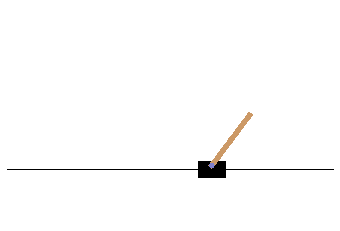

In [3]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(100):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
        
env.close()

# Policy Network

In [4]:
class Policy():
    def __init__(self, state_size=4, action_size=2):
        self.weights = 1e-4*np.random.rand(state_size, action_size)
        
    def forward(self, state):
        x = np.dot(state, self.weights)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probabilities = self.forward(state)
        action = np.argmax(probabilities)
        return action

## Policy of untrained policy network

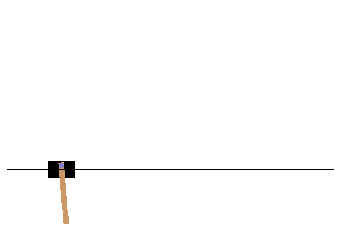

In [5]:
policy = Policy()

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(100):
    action = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
        
env.close()

# Train the Agent

In [6]:
env.seed(0)
np.random.seed(0)

# get the policy network
policy = Policy()

def train_policy_network(n_episodes=1000, max_time=1000, gamma=0.9, print_every=100, noise_scale=1e-2):
    scores_deque = deque(maxlen=100)
    scores = []
    best_Reward = -np.Inf
    best_Weights = policy.weights
    
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        for t in range(max_time):
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done: break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        Reward = sum([a*b for a,b in zip(discounts, rewards)])
        
        if Reward >= best_Reward:
            best_Reward = Reward
            best_Weights = policy.weights
            noise_scale = max(1e-3, noise_scale/2)
            policy.weights += noise_scale * np.random.rand(*policy.weights.shape)
        else:
            noise_scale = min(2, noise_scale * 2)
            policy.weights = best_Weights + noise_scale * np.random.rand(*policy.weights.shape)
            
        if i_episode % print_every == 0:
            print('Episode {}\tLatest Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(scores_deque)))
    return scores

scores = train_policy_network()

Episode 100	Latest Score: 200.00	Average Score: 142.67
Episode 200	Latest Score: 200.00	Average Score: 200.00
Episode 300	Latest Score: 200.00	Average Score: 200.00
Episode 400	Latest Score: 200.00	Average Score: 200.00
Episode 500	Latest Score: 200.00	Average Score: 200.00
Episode 600	Latest Score: 200.00	Average Score: 200.00
Episode 700	Latest Score: 200.00	Average Score: 200.00
Episode 800	Latest Score: 200.00	Average Score: 200.00
Episode 900	Latest Score: 200.00	Average Score: 200.00
Episode 1000	Latest Score: 200.00	Average Score: 200.00


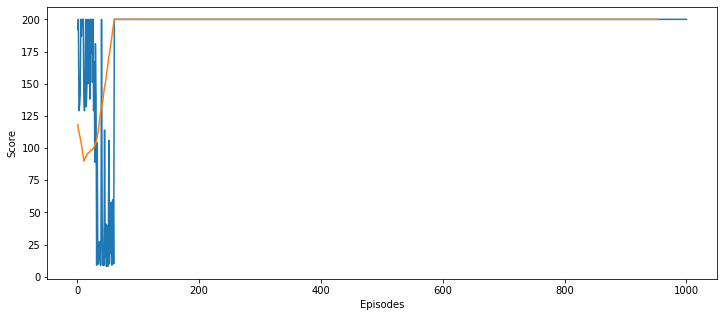

In [7]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

running_mean_scores = running_mean(scores, 50)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(running_mean_scores)+1), running_mean_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

# Trained Agent

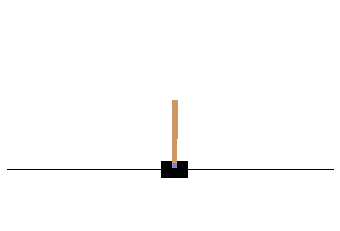

In [10]:
import imageio
images = []

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(10000):
    action = policy.act(state)
    frame = env.render(mode='rgb_array')
    images.append(frame)
    img.set_data(frame) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break
        
env.close()
kargs = { 'fps': 100 }
imageio.mimsave('2_trained_hill_climbing.gif', images, **kargs)

In [11]:
policy.weights

array([[3.32797368, 3.51993745],
       [3.79944585, 3.8632372 ],
       [3.66558546, 4.87998646],
       [5.32811926, 6.45812808]])